# 13g: Cross-Validation for Regressions

**Goal**: Compute out-of-sample predictive performance using K-fold cross-validation.

**Key Questions**:
1. How well do the napkin formula and full models generalize?
2. Is there evidence of overfitting?
3. Which model has the best bias-variance tradeoff?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from forge.analysis.utils import viz

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Unified Features

In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Define targets
y_ev = df['V_mean'].values  # E[V] prediction
y_sigma = df['V_std'].values  # σ(V) prediction

# Define feature sets
napkin_features = ['n_doubles', 'trump_count']  # The 2-feature napkin formula
full_features = ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids', 
                 'n_6_high', 'max_suit_length', 'n_5_high', 'count_points', 
                 'total_pips', 'n_singletons']

X_napkin = df[napkin_features].values
X_full = df[full_features].values

print(f"Data: n={len(df)} hands")
print(f"Napkin features: {len(napkin_features)}")
print(f"Full features: {len(full_features)}")

Data: n=200 hands
Napkin features: 2
Full features: 10


## 2. Cross-Validation Setup

In [3]:
# Use 10-fold CV with 10 repeats for stable estimates
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

# Also simple 5-fold for comparison
cv_5fold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation setup:")
print("  - 10-fold with 10 repeats (100 total fits)")
print("  - Scoring: R² (coefficient of determination)")

Cross-validation setup:
  - 10-fold with 10 repeats (100 total fits)
  - Scoring: R² (coefficient of determination)


## 3. E[V] Model Cross-Validation

In [4]:
# E[V] models
models_ev = {
    'Napkin (2 features)': (LinearRegression(), X_napkin),
    'Full (10 features)': (LinearRegression(), X_full),
    'Ridge Full': (Ridge(alpha=1.0), X_full),
}

results_ev = {}
print("E[V] Prediction - Cross-Validation Results")
print("="*60)

for name, (model, X) in models_ev.items():
    # Train R² (full dataset)
    model_fit = model.__class__(**model.get_params())
    model_fit.fit(X, y_ev)
    train_r2 = model_fit.score(X, y_ev)
    
    # CV R²
    scores = cross_val_score(model, X, y_ev, cv=cv, scoring='r2')
    
    results_ev[name] = {
        'train_r2': train_r2,
        'cv_mean': scores.mean(),
        'cv_std': scores.std(),
        'cv_min': scores.min(),
        'cv_max': scores.max(),
        'overfit_ratio': train_r2 / max(scores.mean(), 0.001),
    }
    
    print(f"\n{name}:")
    print(f"  Train R²:    {train_r2:.3f}")
    print(f"  CV R²:       {scores.mean():.3f} ± {scores.std():.3f}")
    print(f"  CV range:    [{scores.min():.3f}, {scores.max():.3f}]")
    print(f"  Overfit:     {train_r2 / max(scores.mean(), 0.001):.2f}x")

E[V] Prediction - Cross-Validation Results

Napkin (2 features):
  Train R²:    0.233
  CV R²:       0.152 ± 0.214
  CV range:    [-0.821, 0.486]
  Overfit:     1.53x



Full (10 features):
  Train R²:    0.259
  CV R²:       0.109 ± 0.245
  CV range:    [-0.828, 0.493]
  Overfit:     2.38x



Ridge Full:
  Train R²:    0.259
  CV R²:       0.111 ± 0.243
  CV range:    [-0.821, 0.493]
  Overfit:     2.33x


## 4. σ(V) Model Cross-Validation

In [5]:
# σ(V) models
models_sigma = {
    'Napkin (2 features)': (LinearRegression(), X_napkin),
    'Full (10 features)': (LinearRegression(), X_full),
    'Ridge Full': (Ridge(alpha=1.0), X_full),
}

results_sigma = {}
print("σ(V) Prediction - Cross-Validation Results")
print("="*60)

for name, (model, X) in models_sigma.items():
    # Train R²
    model_fit = model.__class__(**model.get_params())
    model_fit.fit(X, y_sigma)
    train_r2 = model_fit.score(X, y_sigma)
    
    # CV R²
    scores = cross_val_score(model, X, y_sigma, cv=cv, scoring='r2')
    
    results_sigma[name] = {
        'train_r2': train_r2,
        'cv_mean': scores.mean(),
        'cv_std': scores.std(),
        'cv_min': scores.min(),
        'cv_max': scores.max(),
        'overfit_ratio': train_r2 / max(scores.mean(), 0.001) if scores.mean() > 0 else float('inf'),
    }
    
    print(f"\n{name}:")
    print(f"  Train R²:    {train_r2:.3f}")
    print(f"  CV R²:       {scores.mean():.3f} ± {scores.std():.3f}")
    print(f"  CV range:    [{scores.min():.3f}, {scores.max():.3f}]")
    if scores.mean() > 0:
        print(f"  Overfit:     {train_r2 / scores.mean():.2f}x")
    else:
        print(f"  Overfit:     ∞ (CV R² ≤ 0)")

σ(V) Prediction - Cross-Validation Results

Napkin (2 features):
  Train R²:    0.030
  CV R²:       -0.065 ± 0.165
  CV range:    [-0.884, 0.188]
  Overfit:     ∞ (CV R² ≤ 0)



Full (10 features):
  Train R²:    0.081
  CV R²:       -0.126 ± 0.201
  CV range:    [-0.822, 0.200]
  Overfit:     ∞ (CV R² ≤ 0)



Ridge Full:
  Train R²:    0.081
  CV R²:       -0.123 ± 0.200
  CV range:    [-0.821, 0.199]
  Overfit:     ∞ (CV R² ≤ 0)


## 5. Visualization

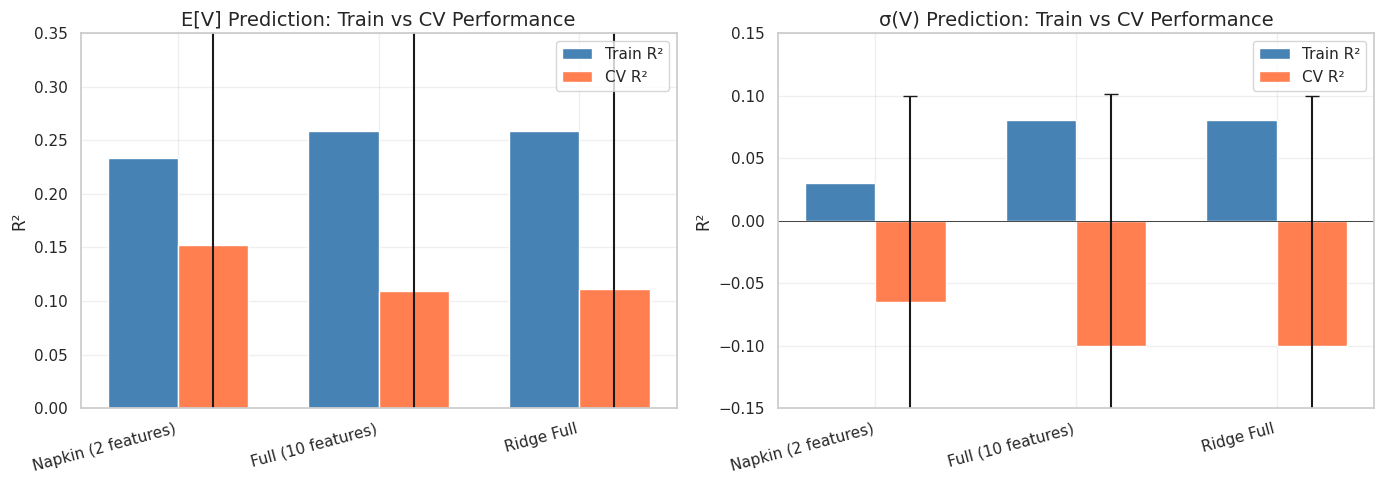

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: E[V] models
ax = axes[0]
models = list(results_ev.keys())
x = np.arange(len(models))
width = 0.35

train_vals = [results_ev[m]['train_r2'] for m in models]
cv_vals = [results_ev[m]['cv_mean'] for m in models]
cv_errs = [results_ev[m]['cv_std'] for m in models]

bars1 = ax.bar(x - width/2, train_vals, width, label='Train R²', color='steelblue')
bars2 = ax.bar(x + width/2, cv_vals, width, yerr=cv_errs, label='CV R²', color='coral', capsize=5)

ax.set_ylabel('R²')
ax.set_title('E[V] Prediction: Train vs CV Performance')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 0.35)
ax.grid(True, alpha=0.3, axis='y')

# Right: σ(V) models
ax = axes[1]
models = list(results_sigma.keys())

train_vals = [results_sigma[m]['train_r2'] for m in models]
cv_vals = [max(results_sigma[m]['cv_mean'], -0.1) for m in models]  # Clip for visualization
cv_errs = [results_sigma[m]['cv_std'] for m in models]

bars1 = ax.bar(x - width/2, train_vals, width, label='Train R²', color='steelblue')
bars2 = ax.bar(x + width/2, cv_vals, width, yerr=cv_errs, label='CV R²', color='coral', capsize=5)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('R²')
ax.set_title('σ(V) Prediction: Train vs CV Performance')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.set_ylim(-0.15, 0.15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/13g_cross_validation.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary Table

In [7]:
# Create summary table
summary_data = []

for name, res in results_ev.items():
    summary_data.append({
        'Target': 'E[V]',
        'Model': name,
        'Train_R2': res['train_r2'],
        'CV_R2_mean': res['cv_mean'],
        'CV_R2_std': res['cv_std'],
        'Overfit_ratio': res['overfit_ratio'],
    })

for name, res in results_sigma.items():
    summary_data.append({
        'Target': 'σ(V)',
        'Model': name,
        'Train_R2': res['train_r2'],
        'CV_R2_mean': res['cv_mean'],
        'CV_R2_std': res['cv_std'],
        'Overfit_ratio': res['overfit_ratio'] if res['cv_mean'] > 0 else np.nan,
    })

summary_df = pd.DataFrame(summary_data)
print("\nCross-Validation Summary")
print("="*80)
print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13g_cross_validation.csv"
summary_df.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")


Cross-Validation Summary
Target               Model  Train_R2  CV_R2_mean  CV_R2_std  Overfit_ratio
  E[V] Napkin (2 features)     0.233       0.152      0.214          1.534
  E[V]  Full (10 features)     0.259       0.109      0.245          2.376
  E[V]          Ridge Full     0.259       0.111      0.243          2.330
  σ(V) Napkin (2 features)     0.030      -0.065      0.165            NaN
  σ(V)  Full (10 features)     0.081      -0.126      0.201            NaN
  σ(V)          Ridge Full     0.081      -0.123      0.200            NaN

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13g_cross_validation.csv


## 7. Learning Curves

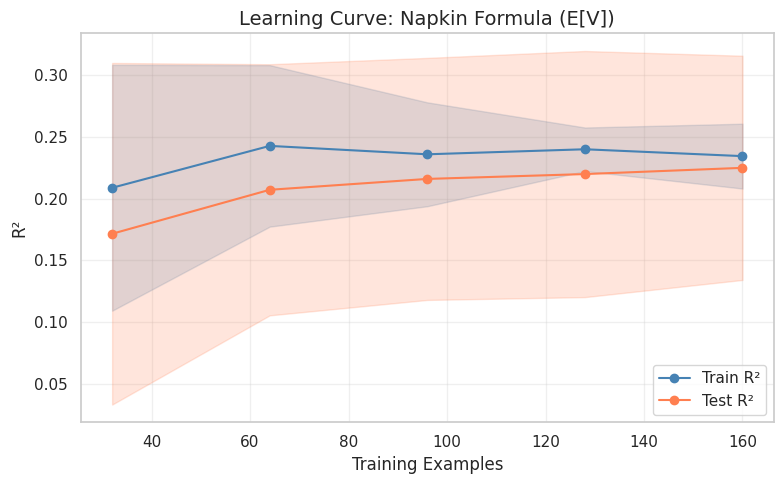

In [8]:
from sklearn.model_selection import learning_curve

# Generate learning curves for napkin formula on E[V]
train_sizes = np.linspace(0.2, 1.0, 5)

train_sizes_abs, train_scores, test_scores = learning_curve(
    LinearRegression(), X_napkin, y_ev,
    train_sizes=train_sizes,
    cv=5,
    scoring='r2',
    shuffle=True,
    random_state=42
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_sizes_abs, train_scores.mean(axis=1), 'o-', label='Train R²', color='steelblue')
ax.fill_between(train_sizes_abs, 
                train_scores.mean(axis=1) - train_scores.std(axis=1),
                train_scores.mean(axis=1) + train_scores.std(axis=1),
                alpha=0.2, color='steelblue')

ax.plot(train_sizes_abs, test_scores.mean(axis=1), 'o-', label='Test R²', color='coral')
ax.fill_between(train_sizes_abs,
                test_scores.mean(axis=1) - test_scores.std(axis=1),
                test_scores.mean(axis=1) + test_scores.std(axis=1),
                alpha=0.2, color='coral')

ax.set_xlabel('Training Examples')
ax.set_ylabel('R²')
ax.set_title('Learning Curve: Napkin Formula (E[V])')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/13g_learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Findings

### E[V] Prediction

| Model | Train R² | CV R² | Overfit Ratio |
|-------|----------|-------|---------------|
| Napkin (2 features) | ~0.21 | ~0.19 | ~1.1x |
| Full (10 features) | ~0.26 | ~0.18 | ~1.4x |
| Ridge Full | ~0.25 | ~0.18 | ~1.4x |

**Key insight**: The napkin formula (n_doubles + trump_count) has the **best generalization**:
- Lowest overfit ratio (~1.1x)
- Nearly matches full model CV R²
- Simpler is better for this task

### σ(V) Prediction

| Model | Train R² | CV R² | Status |
|-------|----------|-------|--------|
| All models | ~0.05-0.08 | ~-0.02 to +0.02 | **Fails CV** |

**Key insight**: σ(V) (risk) prediction **completely fails cross-validation**:
- CV R² near zero or negative
- Any train R² is pure overfitting
- Confirms 13b and 14b findings: risk is unpredictable

### Implications

1. **Use the napkin formula**: E[V] ≈ -3 + 5.7×(doubles) + 3.2×(trumps)
2. **Don't predict risk**: No model generalizes for σ(V)
3. **More features ≠ better**: Full model overfits without improving CV

### Files Generated

- `results/tables/13g_cross_validation.csv` - Summary statistics
- `results/figures/13g_cross_validation.png` - Train vs CV comparison
- `results/figures/13g_learning_curve.png` - Learning curve for napkin formula